In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import signal,stats
from ephysvibe.trials.spikes import firing_rate
from ephysvibe.trials import select_trials
from ephysvibe.spike_sorting import config
from ephysvibe.task import def_task,task_constants
from collections import defaultdict
from typing import Dict
import logging
from scipy import fft,signal
import os
from sklearn.model_selection import train_test_split, GridSearchCV,KFold,cross_val_score,StratifiedKFold
from sklearn.svm import SVC,LinearSVC
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn import metrics
from multiprocessing import Pool
from ephysvibe.structures.trials_data import TrialsData
seed=2023

In [2]:
def moving_average(data:np.ndarray,win:int, step:int=1)-> np.ndarray:
    d_shape=data.shape
    d_avg = np.zeros((d_shape[0],d_shape[1],int(np.floor(d_shape[2]/step))))
    count = 0
    for i_step in np.arange(0,d_shape[2]-step,step):
        d_avg[:,:,count] = np.mean(data[:,:,i_step:i_step+win],axis=2)
        count +=1
    return d_avg

In [3]:
def get_avg_fr(filepath,cgroup,win,step,in_out="in",e_align="sample_on",t_before=200,to_decode='samples'):
    print(filepath)
    data = TrialsData.from_python_hdf5(filepath)
    
    trial_idx = np.where(np.logical_and(data.trial_error == 0, data.block == 1))[0]
    if np.any(np.isnan(data.neuron_cond)):
        neuron_cond = np.ones(len(data.clustersgroup))
    else:
        neuron_cond=data.neuron_cond
    task = def_task.create_task_frame(
        condition=data.condition[trial_idx],
        test_stimuli=data.test_stimuli[trial_idx],
        samples_cond=task_constants.SAMPLES_COND,
        neuron_cond = neuron_cond,
    )
    if cgroup == 'all':
        neurons = np.where(data.clustersgroup != cgroup)[0]
    else:
        neurons = np.where(data.clustersgroup == cgroup)[0]

    task = task[np.logical_and(np.in1d(task['i_neuron'].values,neurons),task['in_out']==in_out)]

    if to_decode == 'samples': 
        task=task[task['sample']!='o0_c0']
    elif to_decode == 'neutral':
        task['sample'].replace(['o1_c1', 'o1_c5', 'o5_c1', 'o5_c5'],'no_neutral',inplace=True)
    elif to_decode == 'colors': 
        task=task[task['sample']!='o0_c0']
        task['sample'].replace(['o1_c1', 'o5_c1'],'c1',inplace=True)
        task['sample'].replace(['o1_c5', 'o5_c5'],'c5',inplace=True)
    elif to_decode == 'orientation': 
        task=task[task['sample']!='o0_c0']
        task['sample'].replace(['o1_c1', 'o1_c5'],'o1',inplace=True)
        task['sample'].replace(['o5_c1', 'o5_c5'],'o5',inplace=True)
    else:
        print('Error: to_decode must be "samples" or "neutral"')

    # split in two groups where the neurons in each have the same trials in in or out
    task_1 = task[task['i_neuron']==neurons[0]].copy()
    trials_neuron = task_1['trial_idx'].values
    task_1['trial_idx'] = task_1['trial_idx'].replace(trials_neuron,np.arange(0,len(trials_neuron)))
    t_neurons = task[np.in1d(task['trial_idx'].values,trials_neuron)]['i_neuron'].unique()
    t_neurons_2=neurons[~np.in1d(neurons,t_neurons)]
    task_all = [task_1]
    if len(t_neurons_2) != 0:
        trials_neuron_2 = task[task['i_neuron']==t_neurons_2[0]]['trial_idx'].values
        trials_neuron = [trials_neuron,trials_neuron_2]
        t_neurons = [t_neurons,t_neurons_2]
        task_2 = task[task['i_neuron']==t_neurons_2[0]].copy()
        task_2['trial_idx'] = task_2['trial_idx'].replace(trials_neuron_2,np.arange(0,len(trials_neuron_2)))
        task_all = [task_1,task_2]
    else:
        trials_neuron = [trials_neuron]
        t_neurons = [t_neurons]
    

    sp_avg_all = []
    for i_task, (trial_idx_n, neurons,task) in enumerate(zip(trials_neuron,t_neurons,task_all)):
        min_task = task.groupby(["sample"]).count().min().min()
        # check number of trials
        if min_task>=30:
            trials_s_on = data.code_samples[
                trial_idx[trial_idx_n],
                np.where(data.code_numbers[trial_idx[trial_idx_n]] == task_constants.EVENTS_B1[e_align])[
                    1
                ],
            ]
            shifts = -(trials_s_on - t_before).astype(int)
            shifts = shifts[:,np.newaxis]
            shift_sp = TrialsData.indep_roll(data.sp_samples[trial_idx[trial_idx_n]][:,neurons], shifts, axis=2)[:,:, :1600]
            sp_avg = moving_average(shift_sp, win=win, step=step)
            sp_avg_all.append(sp_avg)
        else:
            task_all.pop(i_task)
    return task_all,sp_avg_all

In [4]:
file1 = open("/home/INT/losada.c/Documents/codes/run_pipelines/paths_decoding.txt", "r")
Lines = file1.readlines()

In [5]:
Lines

['/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_struct/Riesling/lip/2023-01-20_11-00-24_Riesling_lip_e1_r1.h5\n',
 '/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_struct/Riesling/lip/2023-01-23_10-10-27_Riesling_lip_e1_r1.h5\n',
 '/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_struct/Riesling/lip/2022-11-30_10-42-03_Riesling_lip_e1_r1.h5\n',
 '/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_struct/Riesling/lip/2022-12-14_10-50-49_Riesling_lip_e1_r1.h5\n',
 '/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_struct/Riesling/lip/2023-02-24_10-43-44_Riesling_lip_e1_r1.h5\n',
 '/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_struct/Riesling/lip/2023-02-08_10-39-41_Riesling_lip_e1_r1.h5\n',
 '/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_struct/Riesling/lip/2022-12-02_11-01-23_Riesling_lip_e1_r1.h5\n',
 '/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/Open

In [6]:
# load all  files
paths=[]
for line in Lines:
    paths.append(line.strip())
cgroup = "all"
in_out="in"
e_align="sample_on"
win_size = 100
step = 10
fix_duration = 200
sample_duration = 450
fr_samples=[]
max_n_trials = []
num_neurons = 0
to_decode ='neutral'
def load_fr_samples(path:str,n:int):
    task,sp_avg = get_avg_fr(filepath=path,cgroup=cgroup,win=win_size,step=step,in_out=in_out,e_align=e_align,t_before=200,to_decode=to_decode)
    return task,sp_avg
tasks_all,frs_avg_all = [],[]

for n_path in paths:
    task,fr_avg = load_fr_samples(n_path,1)
    tasks_all.append(task)
    frs_avg_all.append(fr_avg)

# with Pool(1) as pool:
#     async_fr = [pool.apply_async(load_fr_samples,args=(paths[n],n)) for n in np.arange(len(paths))] 
#     # frs = [asc.get() for asc in async_fr]
#     for asc in async_fr:
#         tasks_all.append(asc.get()[0])
#         frs_avg_all.append(asc.get()[1])

/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_struct/Riesling/lip/2023-01-20_11-00-24_Riesling_lip_e1_r1.h5


In [29]:
tasks,frs_avg = [],[]
for i in range(len(frs_avg_all)):
    if len(frs_avg_all[i]) >0:
        frs_avg.append(frs_avg_all[i][0])
        tasks.append(tasks_all[i][0])
        if len(frs_avg_all[i]) >1:
            frs_avg.append(frs_avg_all[i][1])
            tasks.append(tasks_all[i][1])

    

In [30]:
# max number of trials that can be used 
min_trials = frs_avg[0].shape[0]
for rec in range(len(tasks)):
    min_n_trials = tasks[rec].groupby(["sample"]).count().min()[0]
    print(min_n_trials, rec)
    min_trials = min_n_trials if min_n_trials < min_trials else min_trials

42 0
34 1
31 2
42 3
68 4
60 5
91 6
92 7
41 8
48 9
47 10
60 11
76 12
35 13
30 14


### SVM2

In [31]:
def sample_df(frs_avg,tasks,min_trials,seed):
    all_df = []
    sample_dict:Dict[str,list] = defaultdict(list)
    
    for i_sample in tasks[0]['sample'].unique(): 
        all_sample_fr=[]
        for fr_s,n_task in zip(frs_avg,tasks): #days
            t_idx = n_task[n_task["sample"]==i_sample].sample(min_trials,random_state=seed)["trial_idx"].values
            sample_fr = fr_s[t_idx]
            all_sample_fr.append(sample_fr)
        all_sample_fr = np.concatenate(all_sample_fr,axis=1)
        sample_dict[i_sample] = all_sample_fr
    return sample_dict

In [32]:
def compute_window_matrix(all_df,n_win):
    y,all_samples = [], []
    for i_sample in all_df.keys(): 
        n_df = all_df[i_sample]
        data = n_df[:,:,n_win]

        all_samples.append(data)
        y.append([i_sample]*data.shape[0])
    return np.concatenate(all_samples,axis=0),np.concatenate(y)

In [33]:
def run_svm_decoder(model,frs_avg,tasks,windows,min_trials,it_seed,n_it,le):
    scores = np.zeros((windows))
    all_df= sample_df(frs_avg,tasks,min_trials,it_seed[n_it])
    #all_df['sample']=le.transform(all_df['sample'])
    for n_win in np.arange(0,windows):
        #  select trials randomly
        X,y = compute_window_matrix(all_df,n_win)
        scaler = MinMaxScaler()
        X = scaler.fit_transform(X)
        y=le.transform(y)
        # split in train and test
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2,shuffle=True, random_state=it_seed[n_it],stratify=y)
        np.random.seed(it_seed[n_it]) 
        idx_swr = np.random.choice(X_train.shape[0], size=X_train.shape[0], replace=True, p=None)
        X_train = X_train[idx_swr]
        y_train = y_train[idx_swr]
        model.fit(X_train,y_train)
        y_predict = model.predict(X_test)
        scores[n_win] = metrics.accuracy_score(y_test,y_predict)# cross_val_score(model, X, y, cv=kf,n_jobs=-1).mean()
    return scores

In [34]:
# plot results
def plot_accuracy(scores,win_steps,neuron_max_shift,x_lim_min,x_lim_max,n_neuron):
    fig,ax = plt.subplots()
    ax.plot(((np.arange(0,len(scores[0]))*win_steps)- neuron_max_shift[n_neuron-1])/1000,scores[:13].mean(axis=0))
    ax.set_xlim(x_lim_min, x_lim_max)
    ax.vlines(
        0, 0.3, 1, color="k", linestyles="dashed"
    )# sample on
    ax.hlines(
        0.5, x_lim_min, x_lim_max, color="gray", linestyles="solid"
    )
    ax.set_title('Is neuron %d engaged in the task?'%(n_neuron))
    ax.set(xlabel="Time (s)", ylabel="SVM classifier accuracy")
    fig.tight_layout(pad=0.2, h_pad=0.2, w_pad=0.2)
    fig.legend(['Accuracy','Sample on'], fontsize=9)

In [35]:
model=  SVC(kernel='linear',C=20,decision_function_shape='ovr',gamma=0.001)

In [36]:
le = LabelEncoder()

le.fit(tasks[0]['sample'].unique())
#all_df['sample']=le.transform(all_df['sample'])
n_iterations = 1000
rng = np.random.default_rng(seed=seed)
it_seed = rng.integers(low=1, high=2023, size=n_iterations, dtype=int)
windows = frs_avg[0].shape[2]
# scores = run_svm_decoder(model,frs_avg,tasks,windows,min_trials,it_seed,n_it=0,le=le)
with Pool(5) as pool:
    async_scores = [pool.apply_async(run_svm_decoder,args=(model,frs_avg,tasks,windows,min_trials,it_seed,n,le)) for n in np.arange(n_iterations)] 
    scores = [asc.get() for asc in async_scores]

In [37]:
n_neurons = 0
for rec in range(len(frs_avg)):
    n_neurons +=frs_avg[rec].shape[1]

Text(0.5, 0.98, 'lip, condition: in, group: all, 121 neurons,window: 100, steps: 10')

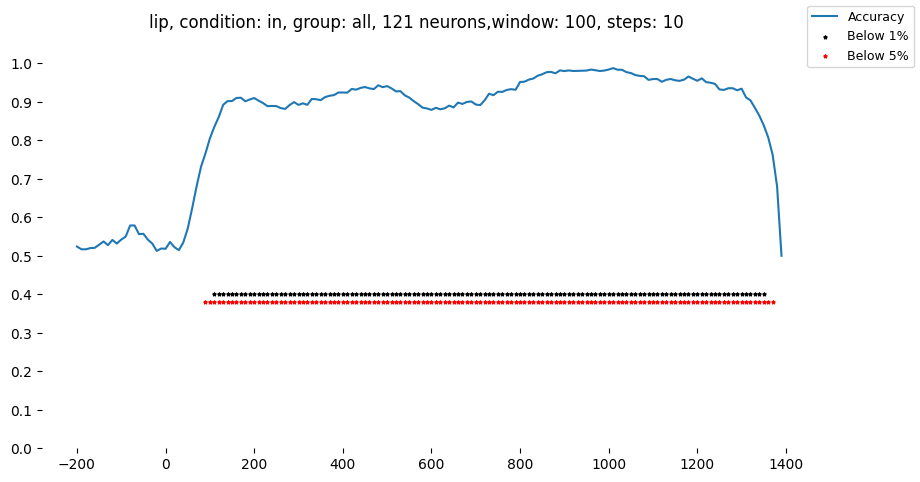

In [38]:
s_path = os.path.normpath(paths[0]).split(os.sep)
fig,ax = plt.subplots(figsize=(10,5))
x = ((np.arange(0, len(scores[0]))) - fix_duration / step) * 10
ax.plot(x, np.array(scores).mean(axis=0), label="Accuracy")
if to_decode == "samples":
    threshole = 0.25
else:
    threshole = 0.5
ss = np.sum(np.array(scores) <= threshole, axis=0) / np.array(scores).shape[0]
mask_inf = ss <= 0.01
mask_inf_5 = ss <= 0.05
# stars
ax.scatter(
    x[mask_inf],
    [threshole - 0.1] * len(x[mask_inf]),
    color="k",
    marker="*",
    label="Below 1%",
    s=6,
)
ax.scatter(
    x[mask_inf_5],
    [threshole - 0.12] * len(x[mask_inf_5]),
    color="r",
    marker="*",
    label="Below 5%",
    s=6,
)
ax.set_ylim(0, 1)
ax.set_yticks(np.arange(0, 1.1, 0.1))
# delete boundaries
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)
fig.legend(fontsize=9)
fig.suptitle(
    "%s, condition: %s, group: %s, %d neurons,window: %d, steps: %d"
    % (s_path[-2], in_out, cgroup, n_neurons, win_size, step)
)

### SVM

In [ ]:
def compute_window_matrix(all_df,n_win,seed):
    y,all_samples = [], []
    for i_sample in all_df['sample'].unique():
        n_df = all_df[all_df['sample']==i_sample]
        data = n_df[[n_win,'neuron','trial_idx']]
        n_pivot = pd.pivot_table(data, values=n_win,index='trial_idx',columns='neuron').reset_index(drop=True).loc[:,0:]
        sample_df = []    
        for n in np.arange(len(n_pivot.columns)):
            sample_df.append(n_pivot.loc[~n_pivot[n].isna(),n].sample(min(max_n_trials),random_state=seed).reset_index(drop=True))
        all_samples.append(pd.concat(sample_df,axis=1))
        y.append([i_sample]*min(max_n_trials))
    return pd.concat(all_samples),np.concatenate(y)


In [ ]:
# plot results
def plot_accuracy(scores,win_steps,neuron_max_shift,x_lim_min,x_lim_max,n_neuron):
    fig,ax = plt.subplots()
    ax.plot(((np.arange(0,len(scores[0]))*win_steps)- neuron_max_shift[n_neuron-1])/1000,scores[:13].mean(axis=0))
    ax.set_xlim(x_lim_min, x_lim_max)
    ax.vlines(
        0, 0.3, 1, color="k", linestyles="dashed"
    )# sample on
    ax.hlines(
        0.5, x_lim_min, x_lim_max, color="gray", linestyles="solid"
    )
    ax.set_title('Is neuron %d engaged in the task?'%(n_neuron))
    ax.set(xlabel="Time (s)", ylabel="SVM classifier accuracy")
    fig.tight_layout(pad=0.2, h_pad=0.2, w_pad=0.2)
    fig.legend(['Accuracy','Sample on'], fontsize=9)

In [ ]:
model=  SVC(kernel='linear',C=20,decision_function_shape='ovr',gamma=0.001)

In [ ]:
def run_svm_decoder(model,all_df,windows,it_seed,n_it):
    scores = np.zeros((windows))
    #for n_it in np.arange(n_iterations):       
    for n_win in np.arange(0,windows):
        #  select trials randomly
        X,y = compute_window_matrix(all_df,n_win,it_seed[n_it])
        # split in train and test
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2,shuffle=True, random_state=it_seed[n_it])
        X_train['label_encoder'] = y_train
        # Sample with replacement (only train set)
        X_train = X_train.sample(len(X_train),random_state=it_seed[n_it],replace=True)
        y_train = X_train['label_encoder']
        X_train = X_train.iloc[:,:-1]
        model.fit(X_train,y_train)
        y_predict = model.predict(X_test)
        scores[n_win] = metrics.accuracy_score(y_test,y_predict)# cross_val_score(model, X, y, cv=kf,n_jobs=-1).mean()
    return scores

In [ ]:
all_df=all_df.replace(np.nan,0)

NameError: name 'all_df' is not defined

In [ ]:
le = LabelEncoder()
le.fit(all_df['sample'].unique())
all_df['sample']=le.transform(all_df['sample'])
n_iterations = 1000
rng = np.random.default_rng(seed=seed)
it_seed = rng.integers(low=1, high=2023, size=n_iterations, dtype=int)
windows=354#0
with Pool(9) as pool:
    async_scores = [pool.apply_async(run_svm_decoder,args=(model,all_df,windows,it_seed,n)) for n in np.arange(n_iterations)] 
    scores2 = [asc.get() for asc in async_scores]

In [ ]:
# good 1
fig,ax = plt.subplots()
ax.plot(((np.arange(0,len(scores2[0])))-fix_duration/10)/100,np.array(scores2).mean(axis=0))

In [ ]:
# mua 100
fig,ax = plt.subplots()
ax.plot(((np.arange(0,len(scores2[0])))-fix_duration)/1000,np.array(scores2).mean(axis=0))

In [ ]:
# good 10
fig,ax = plt.subplots()
ax.plot(((np.arange(0,len(scores2[0])))-fix_duration)/1000,np.array(scores2).mean(axis=0))

In [ ]:
# all 10
fig,ax = plt.subplots()
ax.plot(((np.arange(0,len(scores2[0])))-fix_duration)/1000,np.array(scores2).mean(axis=0))